# Data Preprocessing

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
import os


In [3]:
%pwd

'/Users/c5367983/Desktop/Projects/QuantileX/notebooks'

In [4]:
os.chdir('../')

In [5]:
%pwd

'/Users/c5367983/Desktop/Projects/QuantileX'

In [6]:
!ls

LICENSE          data             requirements.txt
README.md        notebooks        src


In [7]:
from datetime import datetime, timedelta
from ta import add_all_ta_features
import yfinance as yf
import pandas as pd
import numpy as np
import os

In [8]:
class Data:
    def __init__(self, ticker_symbol, period_years, interval):
        self.ticker_symbol = ticker_symbol
        self.period_years = period_years
        self.interval = interval
        self.df = None
        self.preprocessed_df = None
        self.continuous_cols = []
        self.categorical_cols = []

    def download_data(self):
        ticker_obj = yf.Ticker(self.ticker_symbol)
        start_date = (datetime.now() - timedelta(days=self.period_years*365)).strftime('%Y-%m-%d')
        end_date = datetime.now().strftime('%Y-%m-%d')
        df = ticker_obj.history(start = start_date, end=end_date, interval=self.interval)
        self.df = df

    def preprocess(self):
        preprocessed_df = self.df.copy()
        preprocessed_df['Timestamp'] = preprocessed_df.index.astype(np.int64)//10**9
        preprocessed_df['Year'] = preprocessed_df.index.year
        preprocessed_df['Month'] = preprocessed_df.index.month
        preprocessed_df['Day'] = preprocessed_df.index.day
        preprocessed_df['DayOfWeek'] = preprocessed_df.index.dayofweek
        preprocessed_df['MA7_Close'] = preprocessed_df['Close'].rolling(window=7).mean()
        preprocessed_df['MA30_Close'] = preprocessed_df['Close'].rolling(window=30).mean()
        preprocessed_df['Lag1_Close'] = preprocessed_df['Close'].shift(1)
        preprocessed_df['Volume_Change_Pct'] = preprocessed_df['Volume'].pct_change()
        preprocessed_df['target'] = np.where(preprocessed_df['Close'] < preprocessed_df['Open'], 0, 1)
        preprocessed_df['target'] = preprocessed_df['target'].shift(1)

        preprocessed_df_with_ta = add_all_ta_features(preprocessed_df, open="Open", high="High", low="Low", close="Close", volume="Volume")
        
        preprocessed_df_with_ta = self.drop_cols(preprocessed_df_with_ta)
        
        self.preprocessed_df = preprocessed_df_with_ta

    
    def identify_column_type(self, threshold_unique = 100):
             
        for col in self.preprocessed_df.columns:
            unique_values = self.preprocessed_df[col].nunique(dropna=False)
            has_floats = any(self.preprocessed_df[col].apply(lambda x: isinstance(x,float)))
            if has_floats:
                self.continuous_cols.append(col)
                continue
            if unique_values <= threshold_unique:
                self.categorical_cols.append(col)
            else:
                self.continuous_cols.append(col)
    
    def impute_missing_values(self):
        for continuous_col in self.continuous_cols:
            self.preprocessed_df[continuous_col].fillna(self.preprocessed_df[continuous_col].mean(), inplace = True)
        for cotegorical_col in self.categorical_cols:
            mode_value = self.preprocessed_df[cotegorical_col].mode()[0]
            self.preprocessed_df[cotegorical_col].fillna(mode_value, inplace=True)
   
    def drop_cols(self, df):
        for column in df.columns:
            max_count = df[column].value_counts().max()
            if max_count/len(df) > 0.8:
                df.drop(column, axis=1, inplace=True)
        return df

    def save_data(self):
        if not os.path.exists("data"):
            os.makedirs("data")
            
        filepath = os.path.join("data", f"data_{self.ticker_symbol}.csv")
        self.preprocessed_df.to_csv(filepath, index=True)
        print(f"Data saved successfully to {filepath}")


    def run_data(self):
        self.download_data()
        self.preprocess()
        self.identify_column_type()
        self.impute_missing_values()
        self.save_data()


def main():
    data_obj = Data("BTC-USD", 8, "1d")
    data_obj.run_data()

if __name__=="__main__":
    main()
        

                
            
            
            
            
           
        
 

        
        
    
        
        
    

    



/Users/c5367983/anaconda3/envs/quantilex/lib/python3.12/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/c5367983/anaconda3/envs/quantilex/lib/python3.12/site-packages/ta/trend.py:1030: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  self._psar[i] = high2


Data saved successfully to data/data_BTC-USD.csv


/var/folders/9n/3_zg_58x1hl5lwsdqj1dy0tm0000gn/T/ipykernel_59600/4014170937.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.preprocessed_df[continuous_col].fillna(self.preprocessed_df[continuous_col].mean(), inplace = True)
/var/folders/9n/3_zg_58x1hl5lwsdqj1dy0tm0000gn/T/ipykernel_59600/4014170937.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because t

In [9]:
df = pd.read_csv('data/data_BTC-USD.csv')

In [10]:
df.head()

Date        Open        High         Low       Close  \
0  2016-01-30 00:00:00+00:00  378.864990  380.916992  376.490997  378.255005   
1  2016-01-31 00:00:00+00:00  378.292999  380.346985  367.834991  368.766998   
2  2016-02-01 00:00:00+00:00  369.350006  378.071991  367.957001  373.056000   
3  2016-02-02 00:00:00+00:00  372.920013  375.882996  372.920013  374.447998   
4  2016-02-03 00:00:00+00:00  374.645996  374.950012  368.045013  369.949005   

     Volume   Timestamp  Year  Month  Day  ...  momentum_ppo  \
0  30284400  1454112000  2016      1   30  ...      0.935425   
1  37894300  1454198400  2016      1   31  ...      0.935425   
2  51656700  1454284800  2016      2    1  ...      0.935425   
3  40378700  1454371200  2016      2    2  ...      0.935425   
4  45933400  1454457600  2016      2    3  ...      0.935425   

   momentum_ppo_signal  momentum_ppo_hist  momentum_pvo  momentum_pvo_signal  \
0             0.935326          -0.006078      0.705659             0.703517   
1             0.935326          -0.006078      0.705659             0.703517   
2             0.935326          -0.006078      0.705659             0.703517   
3             0.935326          -0.006078      0.705659             0.703517   
4             0.935326          -0.006078      0.705659             0.703517   

   momentum_pvo_hist  momentum_kama  others_dr  others_dlr  others_cr  
0          -0.017496   17398.528152   0.230850    0.161449   0.000000  
1          -0.017496   17398.528152  -2.508362   -2.540358  -2.508362  
2          -0.017496   17398.528152   1.163065    1.156354  -1.374471  
3          -0.017496   17398.528152   0.373134    0.372439  -1.006466  
4          -0.017496   17398.528152  -1.201500   -1.208776  -2.195873  

[5 rows x 97 columns]

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_pearson_correlation(dataset):
    """
    Visualizes the Pearson correlation matrix of a given dataset.

    Parameters:
    - dataset: pandas DataFrame containing the data.

    The function creates a heatmap of the Pearson correlation matrix.
    """
    dataset.drop("Date", axis = 1, inplace=True)
    # Calculate the Pearson correlation matrix
    correlation_matrix = dataset.corr(method='pearson')
    
    # Set up the matplotlib figure
    plt.figure(figsize=(80, 80))
    
    # Generate a heatmap to visualize the correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.9)
    
    # Set titles and labels
    plt.title('Pearson Correlation Matrix', size=15)
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example usage:
# Assuming 'df' is your pandas DataFrame containing the dataset
# visualize_pearson_correlation(df)


In [12]:
visualize_pearson_correlation(df)

# Modeling

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error  
from sklearn.metrics import mean_squared_error   
from sklearn.metrics import r2_score             
import pandas as pd
import numpy as np

In [29]:
data_frame = pd.read_csv('data/data_BTC-USD.csv')

In [30]:
data_frame['Date'] = pd.to_datetime(data_frame['Date'])

In [31]:
data_frame.drop('Date', axis = 1, inplace = True)

In [32]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2920 entries, 0 to 2919
Data columns (total 96 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Open                     2920 non-null   float64
 1   High                     2920 non-null   float64
 2   Low                      2920 non-null   float64
 3   Close                    2920 non-null   float64
 4   Volume                   2920 non-null   int64  
 5   Timestamp                2920 non-null   int64  
 6   Year                     2920 non-null   int64  
 7   Month                    2920 non-null   int64  
 8   Day                      2920 non-null   int64  
 9   DayOfWeek                2920 non-null   int64  
 10  MA7_Close                2920 non-null   float64
 11  MA30_Close               2920 non-null   float64
 12  Lag1_Close               2920 non-null   float64
 13  Volume_Change_Pct        2920 non-null   float64
 14  target                  

## Predict Colse Price with Lasso (L1) regularization

In [42]:
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt

In [34]:
y = data_frame['Close']

In [35]:
X = data_frame.drop('Close', axis = 1)

In [36]:
tscv = TimeSeriesSplit(n_splits=5)

In [37]:
lasso_model = Lasso(alpha=0.1)

Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 2

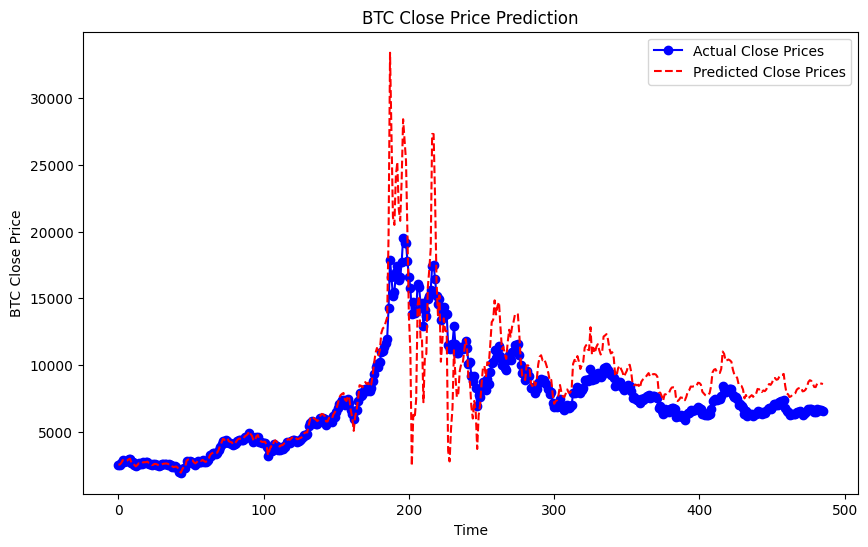

MSE: 5069347.5754, MAE: 1393.5419, R-squared: 0.5893
Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 2

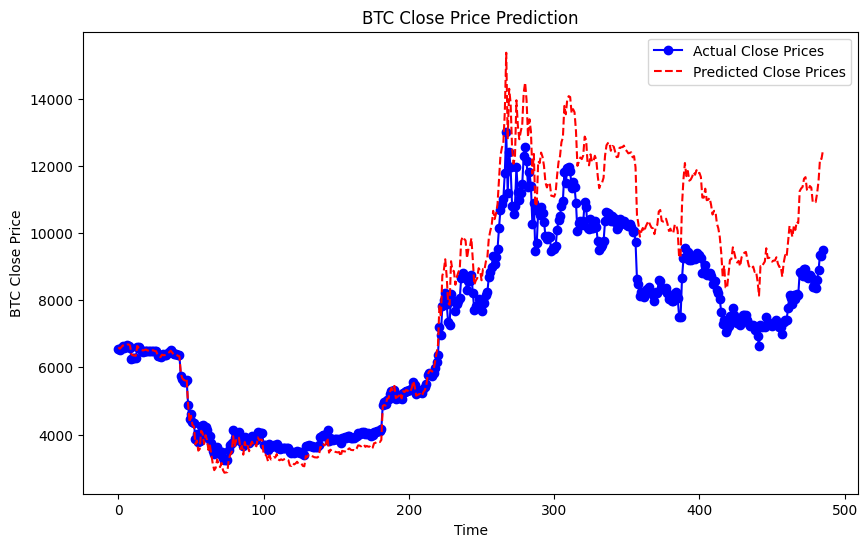

MSE: 1960299.3360, MAE: 1086.7519, R-squared: 0.6937
Train index: [   0    1    2 ... 1459 1460 1461]


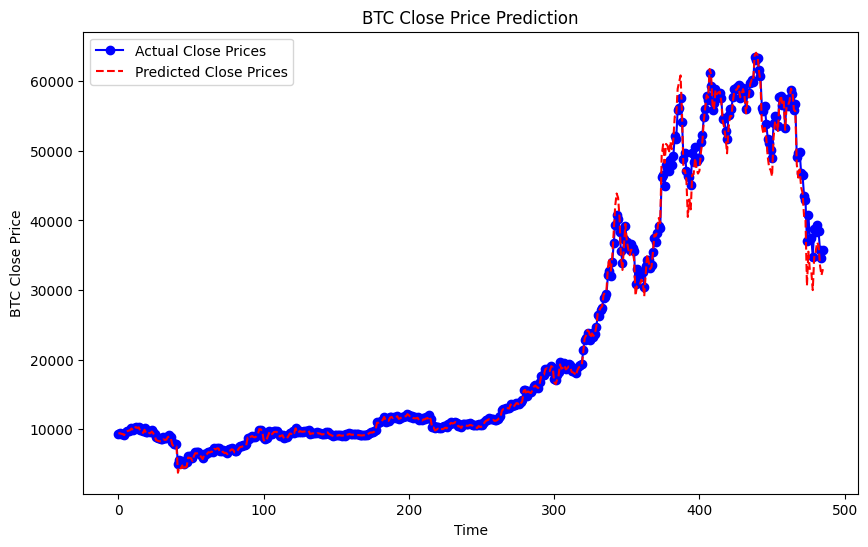

MSE: 1344484.3145, MAE: 594.5561, R-squared: 0.9959
Train index: [   0    1    2 ... 1945 1946 1947]


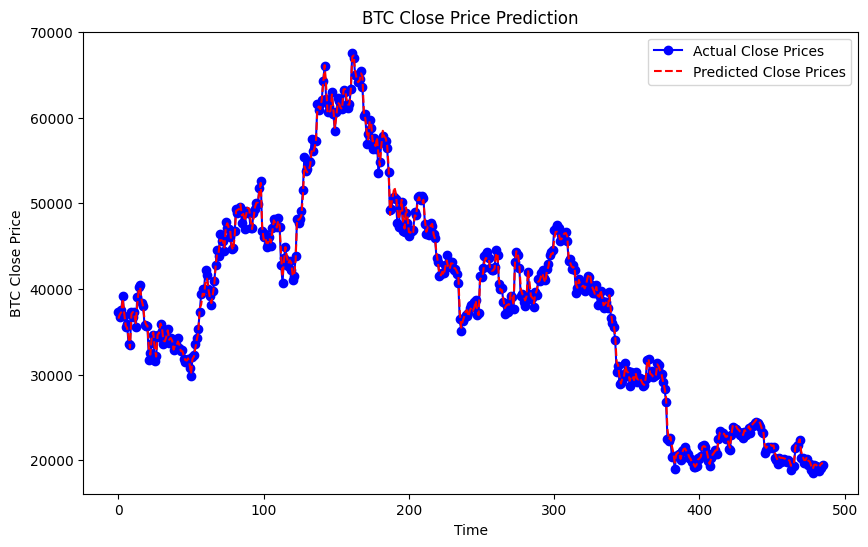

MSE: 223514.8441, MAE: 363.6578, R-squared: 0.9985
Train index: [   0    1    2 ... 2431 2432 2433]


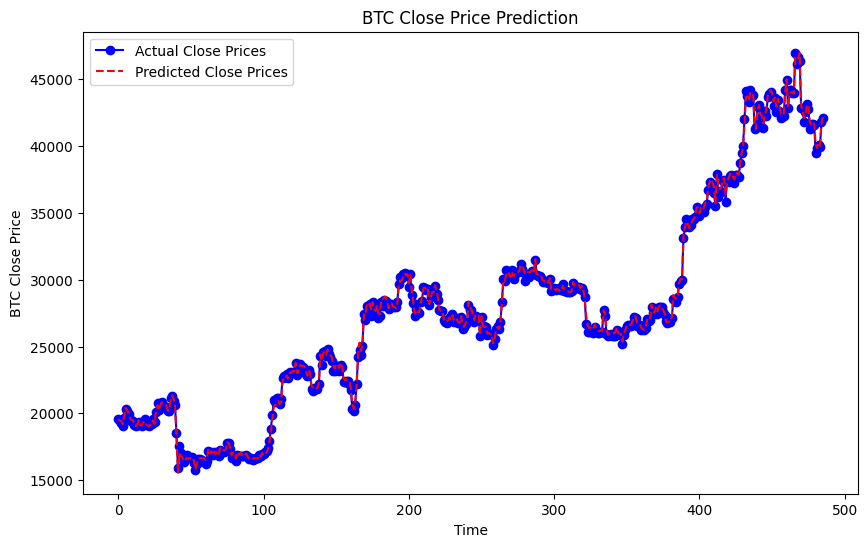

MSE: 33522.6303, MAE: 136.4869, R-squared: 0.9994


In [46]:
for train_index, test_index in tscv.split(X):
    print(f"Train index: {train_index}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    lasso_model.fit(X_train, y_train)
    predictions = lasso_model.predict(X_test)

    # Visualize the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='Actual Close Prices', color='blue', marker='o')
    plt.plot(predictions, label='Predicted Close Prices', color='red', linestyle='--')
    plt.title('BTC Close Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('BTC Close Price')
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")
    